In [84]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from scipy.io import loadmat
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GroupKFold, cross_val_predict

Data type: uint8
Data shape: (512, 512, 7)


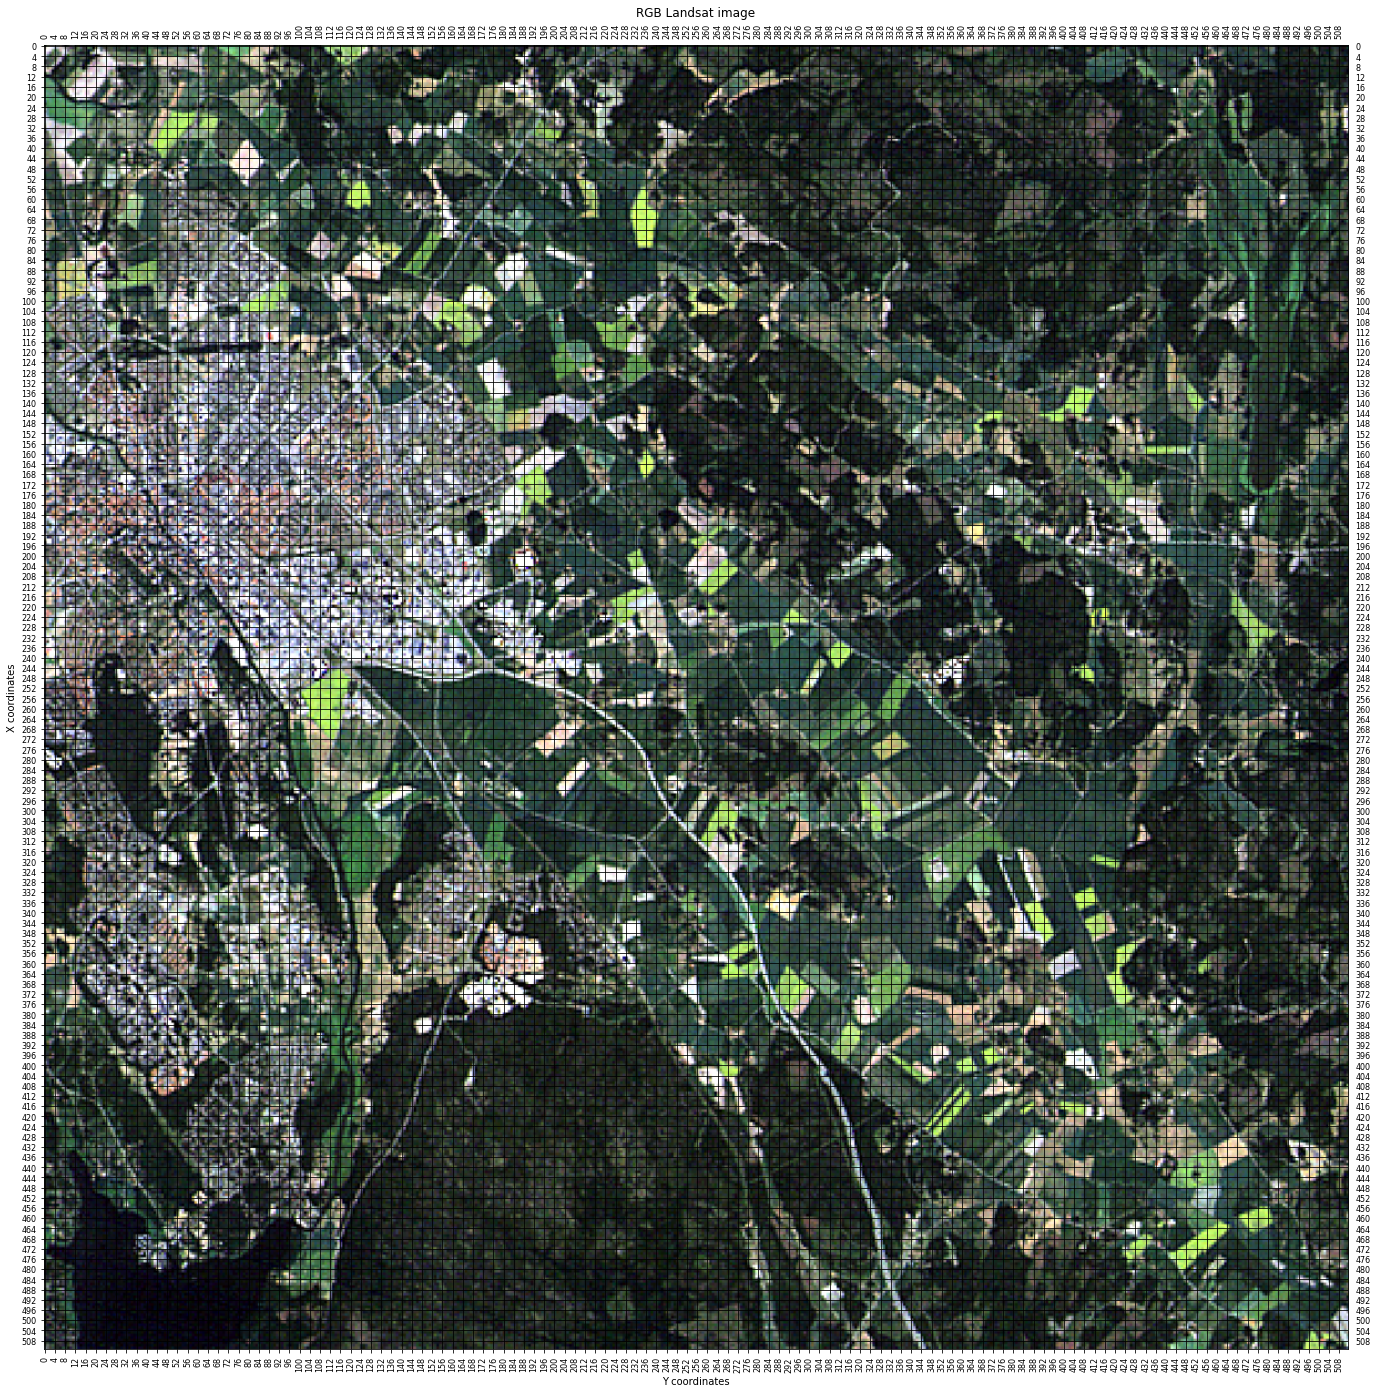

In [2]:
data = loadmat('./data/landsat_data.mat')
im = np.array(data['landsat_data'])
print(f'Data type: {im.dtype}')
print(f'Data shape: {im.shape}')

# Computation of NDVI:
numerator = cv.subtract(src1=im[:,:,3], src2=im[:,:,2])
denominator = cv.addWeighted(src1=im[:,:,3], alpha=0.5, src2=im[:,:,2], beta=0.5, gamma=0)
ndvi = cv.divide(src1=numerator, src2=denominator)
ndvi = np.expand_dims(ndvi, axis=2)
im = np.dstack([im, ndvi])

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))

ax0.imshow(im[:,:, (2,1,0)], interpolation='none')
ax0.set_title('RGB Landsat image')
ax0.set_xticks(np.linspace(start=0, stop=im.shape[0], num=128, endpoint=False).astype(int))
ax0.set_yticks(np.linspace(start=0, stop=im.shape[1], num=128, endpoint=False).astype(int))
ax0.tick_params(axis="x", labelsize=8, rotation=90, labeltop=True)
ax0.tick_params(axis="y", labelsize=8, rotation=0, labelright=True)
ax0.set_xlabel('Y coordinates')
ax0.set_ylabel('X coordinates')
ax0.grid(color='black', linestyle='-', linewidth=0.8)

In [82]:
# Mapping: 1 water, 2 urban area, 3 agriculture area, 4 forest
labels = {1:'Water', 2:'Urban area', 3:'Agricultural area', 4:'Forest'}
data = np.zeros(shape=(im.shape[0], im.shape[1], 2), dtype=np.uint8)

data[491:501, 30:40] = [1,1]
data[112:128, 481:486] = [1,2]
data[143:158, 476:481] = [1,3]

data[153:168, 76:87] = [2,4]
data[230:240, 128:138] = [2,5]
data[184:189, 10:25] = [2,6]
data[158:173, 158:173] = [2,7]

data[353:368, 291:307] = [3,8]
data[261:266, 322:337] = [3,9]
data[122:126, 325:345] = [3,10]
data[58:65, 380:391] = [3,11]

data[460:470, 150:180] = [4,12]
data[163:173, 276:286] = [4,13]
data[476:506, 373:378] = [4,14]
data[220:235, 384:400] = [4,15]

x_coord, y_coord = data[:,:,0].nonzero()
dict_data = {'PolygonID': data[x_coord, y_coord, 1],
     'B1': im[x_coord, y_coord, 0],
     'B2': im[x_coord, y_coord, 1],
     'B3': im[x_coord, y_coord, 2],
     'B4': im[x_coord, y_coord, 3],
     'B5': im[x_coord, y_coord, 4],
     'B6': im[x_coord, y_coord, 5],
     'B7': im[x_coord, y_coord, 6],
     'NDVI': im[x_coord, y_coord, 7],
     'Class': data[x_coord, y_coord, 0]
     }
df_data = pd.DataFrame(data=dict_data, dtype=np.uint8)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   PolygonID  2082 non-null   uint8
 1   B1         2082 non-null   uint8
 2   B2         2082 non-null   uint8
 3   B3         2082 non-null   uint8
 4   B4         2082 non-null   uint8
 5   B5         2082 non-null   uint8
 6   B6         2082 non-null   uint8
 7   B7         2082 non-null   uint8
 8   NDVI       2082 non-null   uint8
 9   Class      2082 non-null   uint8
dtypes: uint8(10)
memory usage: 20.5 KB


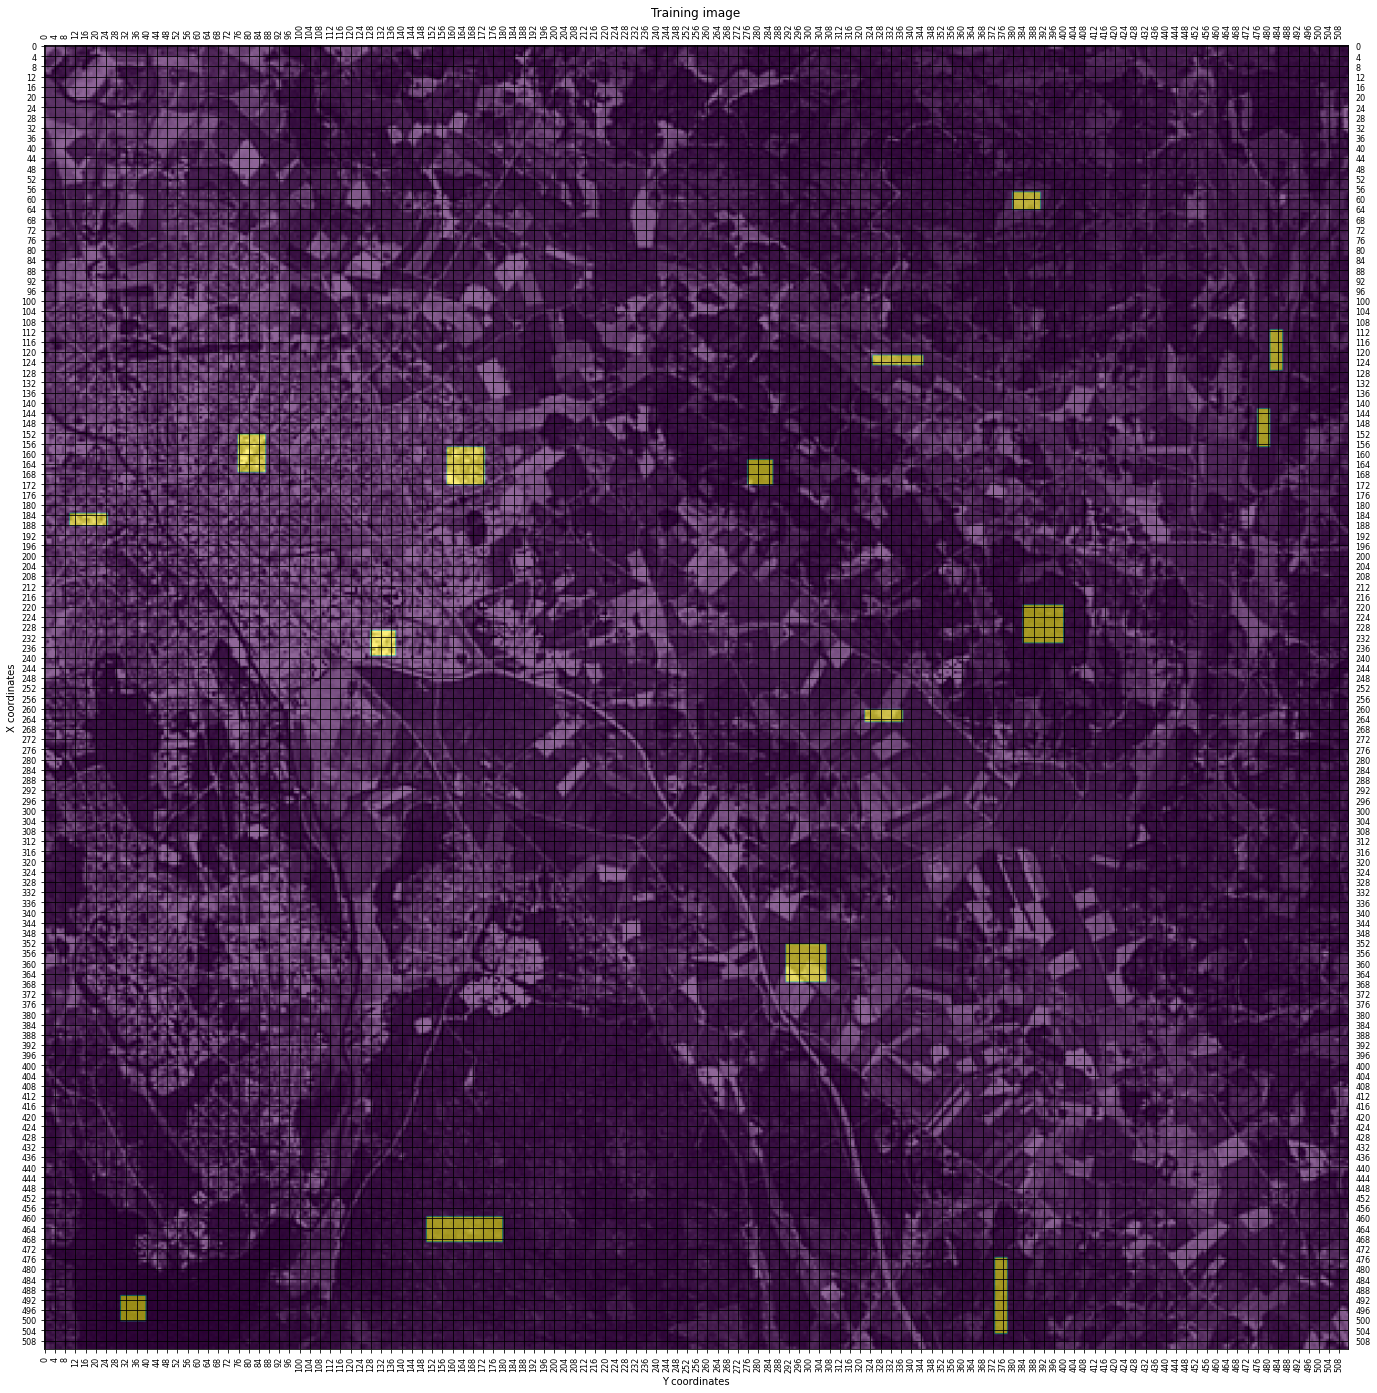

In [4]:
data_mask = np.zeros(shape=data.shape[:-1])
data_mask[np.nonzero(data[:,:,0])] = 255

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))
ax0.imshow(cv.cvtColor(src=im[:,:,(2,1,0)], code=cv.COLOR_RGB2GRAY), interpolation='none', cmap=cm.gray)
ax0.imshow(data_mask, interpolation='none', alpha=0.6)
ax0.set_title('Training image')
ax0.set_xticks(np.linspace(start=0, stop=im.shape[0], num=128, endpoint=False).astype(int))
ax0.set_yticks(np.linspace(start=0, stop=im.shape[1], num=128, endpoint=False).astype(int))
ax0.tick_params(axis="x", labelsize=8, rotation=90, labeltop=True)
ax0.tick_params(axis="y", labelsize=8, rotation=0, labelright=True)
ax0.set_xlabel('Y coordinates')
ax0.set_ylabel('X coordinates')
ax0.grid(color='black', linestyle='-', linewidth=0.8)

In [90]:
data_size = df_data.shape[0]
#trainIndex = np.random.choice(data_size, size=int(0.75*data_size), replace=False)
# train_dataset = df_data.iloc[trainIndex]
# test_dataset = df_data.iloc[~df_data.index.isin(trainIndex)]

# train_x, train_y = train_dataset.drop(columns=['Class', 'PolygonID'], inplace=False), train_dataset['Class']
# test_x, test_y = test_dataset.drop(columns=['Class', 'PolygonID'], inplace=False), test_dataset['Class']

x = df_data.drop(columns=['Class'], inplace=False)
y = df_data['Class']
polygons = df_data['PolygonID'].values
group_kfold = GroupKFold(n_splits=5)
polygon_kfold = group_kfold.split(x, y, polygons)
train_indices, test_indices = [list(traintest) for traintest in zip(*polygon_kfold)]
polygons_cv = [*zip(train_indices,test_indices)]

predictions = cross_val_predict(model, X, y, cv=city_cv)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [91]:
def box_plot(channel):
    feature = train_dataset[f'B{channel}']
    c1 = feature[train_dataset['Class'] == 1]
    c2 = feature[train_dataset['Class'] == 2]
    c3 = feature[train_dataset['Class'] == 3]
    c4 = feature[train_dataset['Class'] == 4]

    feature_dict = {'Water': c1, 'Urban': c2, 'Agriculture': c3, 'Forest': c4}

    fig, ax = plt.subplots()
    ax.set_title(f'Boxplot Channel = {channel}')
    ax.boxplot(feature_dict.values())
    ax.set_xticklabels(feature_dict.keys())

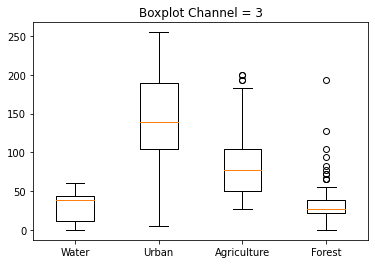

In [80]:
box_plot(3)

In [12]:
rf_classifier = RandomForestClassifier(n_estimators=20, max_features='auto', max_samples=0.75, max_depth=20, oob_score=True)
rf_classifier.fit(X=train_x, y=train_y)
print(f'Out-of-bag accuracy estimate: {rf_classifier.oob_score_}')

Out-of-bag accuracy estimate: 0.9846252402306214


/usr/local/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [13]:
dict_im = {'B1': im[:, :, 0].reshape(-1),
     'B2': im[:, :, 1].reshape(-1),
     'B3': im[:, :, 2].reshape(-1),
     'B4': im[:, :, 3].reshape(-1),
     'B5': im[:, :, 4].reshape(-1),
     'B6': im[:, :, 5].reshape(-1),
     'B7': im[:, :, 6].reshape(-1),
     'NDVI': im[:, :, 7].reshape(-1)
     }
df_im = pd.DataFrame(data=dict_im, dtype=np.uint8)
df_im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B1      262144 non-null  uint8
 1   B2      262144 non-null  uint8
 2   B3      262144 non-null  uint8
 3   B4      262144 non-null  uint8
 4   B5      262144 non-null  uint8
 5   B6      262144 non-null  uint8
 6   B7      262144 non-null  uint8
 7   NDVI    262144 non-null  uint8
dtypes: uint8(8)
memory usage: 2.0 MB


(-0.5, 511.5, 511.5, -0.5)

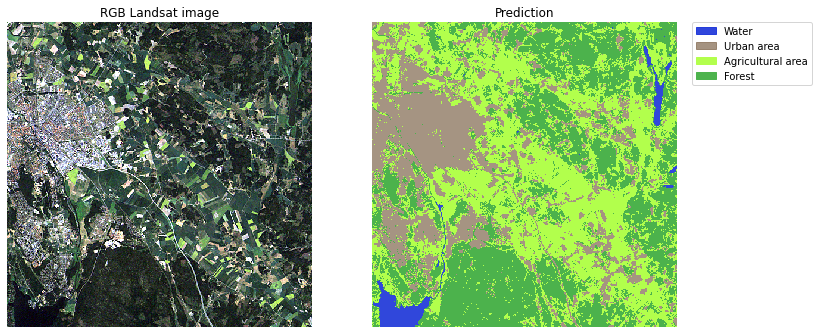

In [83]:
prediction_im = rf_classifier.predict(df_im).reshape(im.shape[:-1])
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax0.imshow(im[:,:,(2,1,0)], interpolation='none')
ax0.set_title('RGB Landsat image')
ax0.axis('off')

cmap = {1:[0.1,0.2,0.85,0.9], 2:[0.5,0.4,0.3,0.7], 3:[0.7,1.0,0.3,1], 4:[0.3,0.7,0.3,1]} #[R,G,B,alpha]
prediction_im = np.array([[cmap[i] for i in j] for j in prediction_im]) 
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
ax1.imshow(prediction_im, interpolation='none')
ax1.set_title('Prediction')
ax1.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.axis('off')

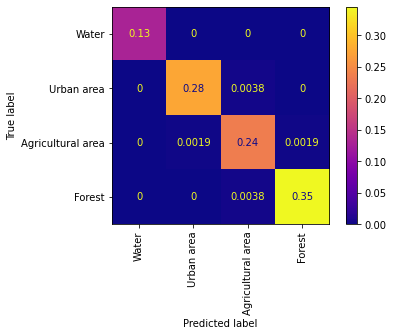

In [49]:
predictions = rf_classifier.predict(test_x)
ConfusionMatrixDisplay.from_predictions(y_true = test_y, y_pred=predictions, normalize='all', display_labels=labels.values(), xticks_rotation='vertical', cmap=cm.plasma)